In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf

In [3]:
! git clone https://github.com/mirzaaa101/Enhancing-Early-Detection-AI-Based-Analysis-of-Skin-Lesions-from-3D-Total-Body-Photographs.git

Cloning into 'Enhancing-Early-Detection-AI-Based-Analysis-of-Skin-Lesions-from-3D-Total-Body-Photographs'...
remote: Enumerating objects: 5787, done.
remote: Counting objects: 100% (2200/2200), done.
remote: Compressing objects: 100% (2198/2198), done.
remote: Total 5787 (delta 3), reused 2194 (delta 2), pack-reused 3587
Receiving objects: 100% (5787/5787), 50.67 MiB | 31.22 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
labels_df = pd.read_csv('/content/Enhancing-Early-Detection-AI-Based-Analysis-of-Skin-Lesions-from-3D-Total-Body-Photographs/isic_balanced_dataset/updated_labels.csv')

image_dir = '/content/Enhancing-Early-Detection-AI-Based-Analysis-of-Skin-Lesions-from-3D-Total-Body-Photographs/isic_balanced_dataset/processed_images'

def load_image(image_id, image_dir):
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    image = Image.open(image_path)
    return np.array(image)

images = []
labels = []

for _, row in labels_df.iterrows():
    image_id = row['isic_id']
    label = row['target']
    image = load_image(image_id, image_dir)
    images.append(image)
    labels.append(label)

print(f"Loaded {len(images)} images with {len(labels)} labels.")

Loaded 2179 images with 2179 labels.


In [5]:
images = np.array(images)
labels = np.array(labels)

In [6]:
def labels2text(label):
    return "Benign" if label==0 else "Malignant"

In [7]:
import matplotlib.pyplot as plt

def show_image(image, index):
    plt.imshow(image)
    plt.axis('off')
    plt.title(labels2text(labels[index]))
    plt.show()

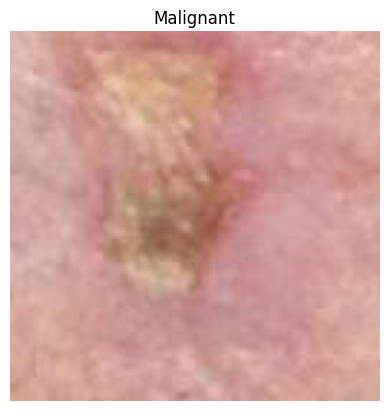

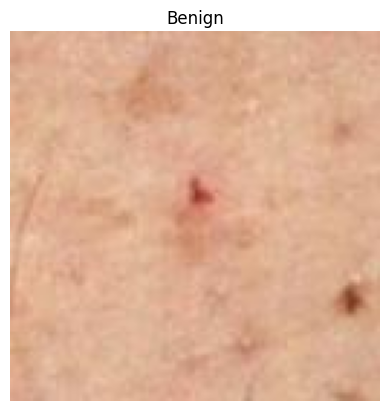

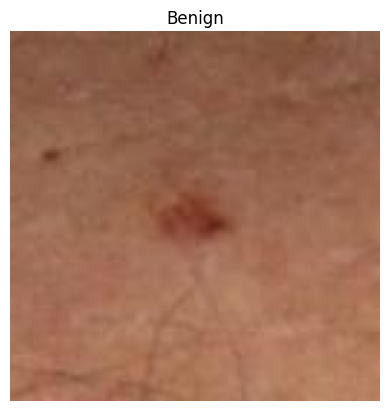

In [8]:
for i in range(3):
    show_image(images[i], i)

In [9]:
def normalize(image):
    image = image / 255.0
    return image

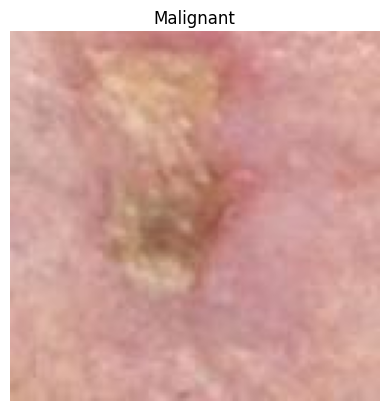

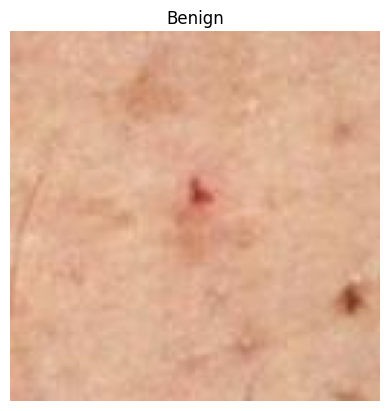

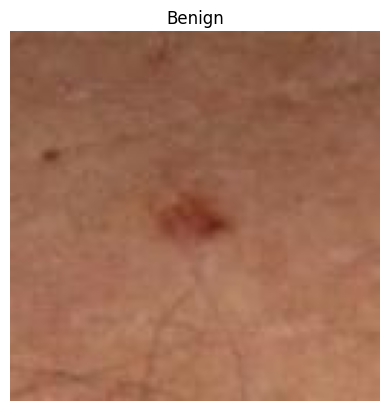

In [10]:
for i in range(3):
    normalized_image = normalize(images[i])
    show_image(normalized_image, i)

In [11]:
X = images.copy()
y = labels.copy()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1743
Validation set size: 218
Test set size: 218


### Applying Xception

In [13]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top = False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
X_train_normalized = normalize(X_train)
X_valid_normalized = normalize(X_valid)

In [15]:
def get_loss_fn():
    return tf.keras.losses.binary_crossentropy

In [16]:
def get_optimizer():
    return tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

In [17]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [18]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss= get_loss_fn(), optimizer=get_optimizer(), metrics=["accuracy"])

history = model.fit(
    X_train_normalized, y_train,
    validation_data=(X_valid_normalized, y_valid),
    callbacks=[early_stopping_cb],
    batch_size=8,
    epochs=15
)

Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 132s 583ms/step - accuracy: 0.7851 - loss: 0.7396 - val_accuracy: 0.8349 - val_loss: 1.5065
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 122s 560ms/step - accuracy: 0.8312 - loss: 0.6663 - val_accuracy: 0.8624 - val_loss: 0.8752
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 128s 586ms/step - accuracy: 0.8860 - loss: 0.4429 - val_accuracy: 0.7661 - val_loss: 1.2532
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 131s 603ms/step - accuracy: 0.9006 - loss: 0.3457 - val_accuracy: 0.8716 - val_loss: 0.8759
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 135s 571ms/step - accuracy: 0.9128 - loss: 0.2530 - val_accuracy: 0.8899 - val_loss: 0.9197
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 124s 571ms/step - accuracy: 0.9103 - loss: 0.1885 - val_accuracy: 0.8761 - val_loss: 0.9582
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 144s 580ms/step - accuracy: 0.8844 - loss: 0.4234 - val_accuracy: 0.8532 - val_loss: 0.8309
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 136s 553ms/step - accuracy: 0.9156 -

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

model.compile(loss= get_loss_fn(), optimizer=get_optimizer(), metrics=["accuracy"])

history = model.fit(
    X_train_normalized, y_train,
    validation_data=(X_valid_normalized, y_valid),
    callbacks=[early_stopping_cb],
    batch_size=8,
    epochs=35
)

Epoch 1/35
218/218 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.6344 - loss: 0.6620 - val_accuracy: 0.8257 - val_loss: 0.5381
Epoch 2/35
218/218 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.7951 - loss: 0.4463 - val_accuracy: 0.8349 - val_loss: 0.3716
Epoch 3/35
218/218 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.8294 - loss: 0.3733 - val_accuracy: 0.7798 - val_loss: 0.5930
Epoch 4/35
218/218 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.8272 - loss: 0.4216 - val_accuracy: 0.8624 - val_loss: 0.3109
Epoch 5/35
127/218 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.8403 - loss: 0.3942